# Notes

In [3]:
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# ! kaggle competitions download -c birdclef-2022 -p /content/drive/MyDrive/
! kaggle competitions download -c birdclef-2022 -p /content/

100% 6.11G/6.12G [00:51<00:00, 105MB/s]
100% 6.12G/6.12G [00:51<00:00, 129MB/s]


In [6]:
# ! mkdir /content/drive/MyDrive/birdclef-2022
# ! unzip /content/drive/MyDrive/birdclef-2022.zip -d /content/drive/MyDrive/birdclef-2022

! mkdir /content/birdclef-2022
! unzip /content/birdclef-2022.zip -d /content/birdclef-2022

Streaming output truncated to the last 5000 lines.
  inflating: /content/birdclef-2022/train_audio/normoc/XC608251.ogg  
  inflating: /content/birdclef-2022/train_audio/normoc/XC608252.ogg  
  inflating: /content/birdclef-2022/train_audio/normoc/XC608253.ogg  
  inflating: /content/birdclef-2022/train_audio/normoc/XC608254.ogg  
  inflating: /content/birdclef-2022/train_audio/normoc/XC608255.ogg  
  inflating: /content/birdclef-2022/train_audio/normoc/XC608256.ogg  
  inflating: /content/birdclef-2022/train_audio/normoc/XC608257.ogg  
  inflating: /content/birdclef-2022/train_audio/normoc/XC608258.ogg  
  inflating: /content/birdclef-2022/train_audio/normoc/XC608259.ogg  
  inflating: /content/birdclef-2022/train_audio/normoc/XC608447.ogg  
  inflating: /content/birdclef-2022/train_audio/normoc/XC608450.ogg  
  inflating: /content/birdclef-2022/train_audio/normoc/XC608452.ogg  
  inflating: /content/birdclef-2022/train_audio/normoc/XC608453.ogg  
  inflating: /content/birdclef-2022/tra

I've released a [training kernel](https://www.kaggle.com/kneroma/clean-fast-simple-bird-identifier-training-colab) and an [inference kernel](https://www.kaggle.com/kneroma/clean-fast-simple-bird-identifier-inference). Both of these kernels use a set of pre-computed mels. Which can be found at:

* https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part1
* https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part2
* https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part3
* https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part4

Unfortunately, these mels are static (7s audio extracts) and you can't get any customization from them. Here, I'm releasing the base kernel that generate them in order to allow everyone to be able to play with the params.

In [33]:
import numpy as np
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile
import pandas as pd
from  IPython.display import Audio
from pathlib import Path

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm
import joblib, json

from  sklearn.model_selection  import StratifiedKFold

import mimetypes
mimetypes.init()
mimetypes.add_type('audio/ogg','.ogg')
import IPython.display as ipd

In [34]:
PART_ID = 0 # The start index in the below list, by changing it you will compute mels on another subset
PART_INDEXES = [0, 14853] 
# PART_INDEXES = [0  3713  7426 11139 14853] 
# PART_INDEXES = np.linspace(0, 14853, 5, dtype=np.intc)
print(PART_INDEXES)


[0, 14853]


In [35]:
SR = 32_000
# DURATION = 7 
DURATION = 7
STEP = 5
SEED = 666

DATA_ROOT = Path("birdclef-2022")
TRAIN_AUDIO_ROOT = Path("birdclef-2022/train_audio")
TRAIN_AUDIO_IMAGES_SAVE_ROOT = Path("/content/drive/MyDrive/audio_images") # Where to save the mels images
TRAIN_AUDIO_IMAGES_SAVE_ROOT.mkdir(exist_ok=True, parents=True)

In [36]:
print(DATA_ROOT.exists())
print(TRAIN_AUDIO_ROOT.exists())

True
True


In [37]:
def get_audio_info(filepath):
    """Get some properties from  an audio file"""
    with SoundFile(filepath) as f:
        sr = f.samplerate
        frames = f.frames
        duration = float(frames)/sr
    return {"frames": frames, "sr": sr, "duration": duration}

In [38]:
def make_df(n_splits=5, seed=SEED, nrows=None):
    
    df = pd.read_csv(DATA_ROOT/"train_metadata.csv", nrows=nrows)

    LABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df["primary_label"].unique()))}
    
    df = df.iloc[PART_INDEXES[PART_ID]: PART_INDEXES[PART_ID+1]]

    df["label_id"] = df["primary_label"].map(LABEL_IDS)

    # df["filepath"] = [str(TRAIN_AUDIO_ROOT/primary_label/filename) for primary_label,filename in zip(df.primary_label, df.filename) ]
    df["filepath"] = [str(TRAIN_AUDIO_ROOT/filename) for primary_label,filename in zip(df.primary_label, df.filename) ]

    pool = joblib.Parallel(4)
    mapper = joblib.delayed(get_audio_info)
    tasks = [mapper(filepath) for filepath in df.filepath]

    df = pd.concat([df, pd.DataFrame(pool(tqdm(tasks)))], axis=1, sort=False)
    
    skf = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
    splits = skf.split(np.arange(len(df)), y=df.label_id.values)
    df["fold"] = -1

    for fold, (train_set, val_set) in enumerate(splits):
        
        df.loc[df.index[val_set], "fold"] = fold

    return LABEL_IDS, df

In [39]:
LABEL_IDS, df = make_df(nrows=None)

df.to_csv("/content/drive/MyDrive/rich_train_metadata.csv", index=True)
with open("/content/drive/MyDrive/LABEL_IDS.json", "w") as f:
    json.dump(LABEL_IDS, f)

print(df.shape)
df.head()

  0%|          | 0/14852 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


(14852, 19)


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename,label_id,filepath,frames,sr,duration,fold
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg,0,birdclef-2022/train_audio/afrsil1/XC125458.ogg,355265,32000,11.102031,3
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg,0,birdclef-2022/train_audio/afrsil1/XC175522.ogg,1504653,32000,47.020406,3
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg,0,birdclef-2022/train_audio/afrsil1/XC177993.ogg,1720320,32000,53.760000,2
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg,0,birdclef-2022/train_audio/afrsil1/XC205893.ogg,3375438,32000,105.482438,1
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg,0,birdclef-2022/train_audio/afrsil1/XC207431.ogg,108669,32000,3.395906,4


In [40]:
df["fold"].value_counts()

1    2971
0    2971
3    2970
2    2970
4    2970
Name: fold, dtype: int64

In [ ]:
# pd.set_option('display.max_rows', None)
df["primary_label"].value_counts()

brnowl     500
skylar     500
norcar     500
mallar3    500
houspa     500
          ... 
puaioh       3
layalb       3
akikik       2
crehon       2
maupar       1
Name: primary_label, Length: 152, dtype: int64

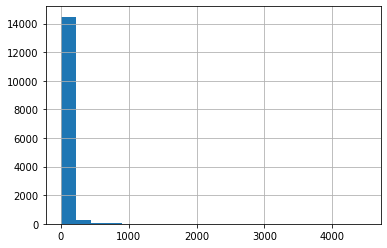

In [ ]:
df["duration"].hist(bins=20)

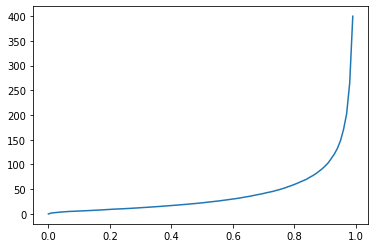

In [ ]:
df["duration"].quantile(np.arange(0, 1, 0.01)).plot()

In [41]:
class MelSpecComputer:
    def __init__(self, sr, n_mels, fmin, fmax, **kwargs):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax
        kwargs["n_fft"] = kwargs.get("n_fft", self.sr//10)
        kwargs["hop_length"] = kwargs.get("hop_length", self.sr//(10*4))
        self.kwargs = kwargs

    def __call__(self, y):
        #assert((y.shape)[0] == 2) 

        #print(f"y shape {y.shape}")

        melspec = lb.feature.melspectrogram(
            y, sr=self.sr, n_mels=self.n_mels, fmin=self.fmin, fmax=self.fmax, **self.kwargs,
        )

        melspec = lb.power_to_db(melspec).astype(np.float32)
        # print(f"melspec shape {melspec.shape}")
        return melspec

In [42]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V
 
def crop_or_pad(y, length, is_train=True, start=None):
    if len(y) < length:

        # Concatenate Zeros
        # y = np.concatenate([y, np.zeros(length - len(y))])
        
        # Repeat Previous
        n_repeats = length // len(y)
        epsilon = length % len(y)
        y = np.concatenate([y]*n_repeats + [y[:epsilon]])
        
    elif len(y) > length:
        if not is_train:
            start = start or 0
        else:
            start = start or np.random.randint(len(y) - length)

        y = y[start:start + length]

    return y

def stereo_to_mono(audio):
    if len(audio.shape) > 1:
      audio = audio.sum(axis=1) / 2
    return audio

In [ ]:
# # temporary for removing folder
# import shutil
# # shutil.rmtree(path)
# for bird in df.primary_label.unique():
#     print(bird)
#     path = TRAIN_AUDIO_IMAGES_SAVE_ROOT/bird/bird
#     print(path)
#     shutil.rmtree(path)



In [43]:
class AudioToImage:
    def __init__(self, sr=SR, n_mels=128, fmin=0, fmax=None, duration=DURATION, step=STEP, res_type="kaiser_fast", resample=True):

        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr//2

        self.duration = duration
        self.audio_length = self.duration*self.sr
  
        self.step = step or self.audio_length
        
        self.res_type = res_type
        self.resample = resample

        self.mel_spec_computer = MelSpecComputer(sr=self.sr, n_mels=self.n_mels, fmin=self.fmin,
                                                 fmax=self.fmax)
        
    def audio_to_image(self, audio):
        melspec = self.mel_spec_computer(audio) 
        image = mono_to_color(melspec)
#         image = normalize(image, mean=None, std=None)
        return image

    def __call__(self, row, save=True):
#       max_audio_duration = 10*self.duration
#       init_audio_length = max_audio_duration*row.sr
        
#       start = 0 if row.duration <  max_audio_duration else np.random.randint(row.frames - init_audio_length)
    
      audio, orig_sr = sf.read(row.filepath, dtype="float32")
      audio = stereo_to_mono(audio)

      if self.resample and orig_sr != self.sr:
        audio = lb.resample(audio, orig_sr, self.sr, res_type=self.res_type)
        
      # audios = [audio[i:i+self.audio_length] for i in range(0, max(1, len(audio) - self.audio_length + 1), self.step)]
      audios = [audio[i:i+self.audio_length] for i in range(0, max(1, len(audio)), self.step)]
      # print(f"Audios shape {[audio.shape for audio in audios]}")

      # print(f"Num audios {len(audios)}")
      # print(f"Len audio {len(audio)}")
      # print(f"audio_length + 1 {self.audio_length + 1}")
      # print(f"Value of step {self.step}")

      audios[-1] = crop_or_pad(audios[-1] , length=self.audio_length)
      if(len(audios) > 1):
          audios[-2] = crop_or_pad(audios[-2] , length=self.audio_length)

      images = [self.audio_to_image(audio) for audio in audios]
      print(f"Images shape {[image.shape for image in images]}")
      for i in range(len(images)):
          fig = plt.figure()
          fig.suptitle(f"MelSpec Start {i*5//60}m {i*5%60}s ")
          lbd.specshow(images[i], x_axis='s', y_axis='hz')
      images = np.stack(images)
        
      if save:
        path = TRAIN_AUDIO_IMAGES_SAVE_ROOT/f"{row.filename}.npy"
        path.parent.mkdir(exist_ok=True, parents=True)
        np.save(str(path), images)

      else:
        return  row.filename, images

In [45]:
def get_audios_as_images(df):
    pool = joblib.Parallel(4)
    
    # converter = AudioToImage(step=int(DURATION*0.666*SR)) Why is duration multiplied by 0.666?
    converter = AudioToImage(step=STEP*SR)
    mapper = joblib.delayed(converter)
    tasks = [mapper(row) for row in df.itertuples(False)]
    
    pool(tqdm(tasks))

In [46]:
get_audios_as_images(df)

  0%|          | 0/14852 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Manual Selection of Audio To Convert

Images shape [(128, 281), (128, 281), (128, 281)]


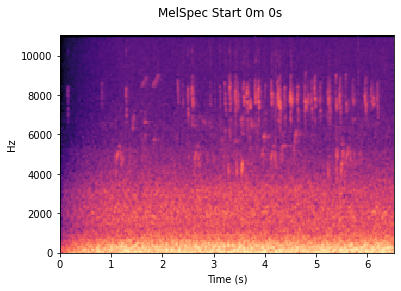

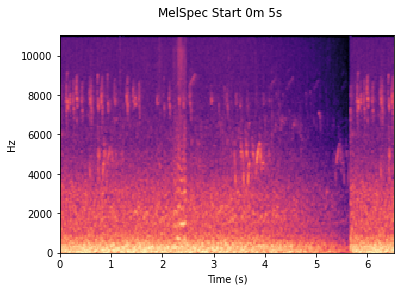

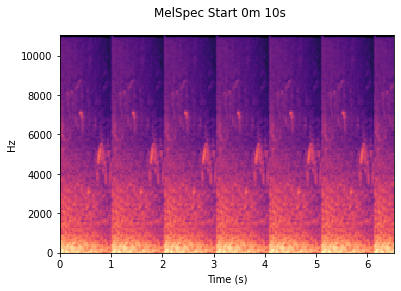

In [28]:
converter = AudioToImage(step=STEP*SR)

file_path = "afrsil1/XC125458.ogg"
# file_path = "afrsil1/XC205893.ogg"
file_name = file_path.split('/')[1]
primary_label = file_path.split('/')[0]

row = df.loc[df['filename'].str.match(file_path)]

for item in row.itertuples(False):
    converter(item)


For Testing


afrsil1


(355265,)
[ 2.7673766e-06 -3.4136076e-06 -2.0889108e-06 ... -1.1547084e-04
  1.0474446e-04  1.7803474e-04]
(355265,)
/content/drive/MyDrive/audio_images/afrsil1/XC125458.ogg.npy
(3, 128, 281)


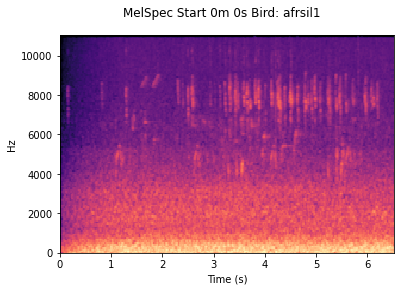

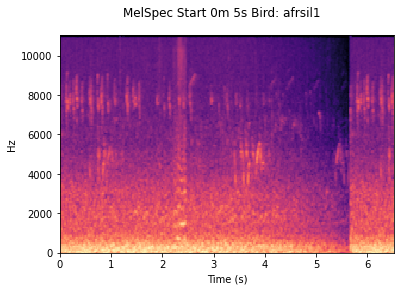

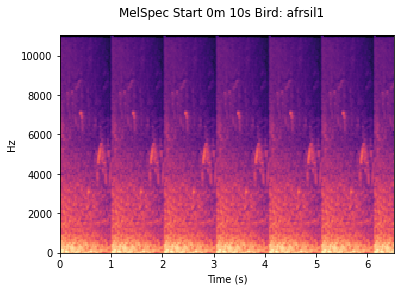

In [47]:
row = df.loc[df['filename'].str.match(file_path)]

for item in row.itertuples(False):
    print(item.primary_label)
    audio, orig_sr = sf.read(item.filepath, dtype="float32")
    ipd.display(ipd.Audio(item.filepath))
        # melspec = lb.feature.melspectrogram(
    #        audio, sr=32000, n_mels=128, fmin=0, fmax=16000 
    #    )
    m = np.array(audio)
    print(audio.shape)
    # print(len(m.shape))
    audio = stereo_to_mono(audio)
    m = np.array(audio)
    print(audio)
    print(m.shape)


    mels = np.load(str((TRAIN_AUDIO_IMAGES_SAVE_ROOT/item.filename).as_posix() + ".npy"))
    print(str((TRAIN_AUDIO_IMAGES_SAVE_ROOT/item.filename).as_posix() + ".npy"))
    print(mels.shape)
    for i in range(len(mels)):
        fig = plt.figure()
        fig.suptitle(f"MelSpec Start {i*5//60}m {i*5%60}s Bird: {item.primary_label}")
        lbd.specshow(mels[i], x_axis='s', y_axis='hz')
    

In [16]:
df = pd.read_csv("/content/drive/MyDrive/rich_train_metadata.csv", nrows=None)

afrsil1
/content/drive/MyDrive/audio_images/afrsil1/afrsil1/XC125458.ogg.npy
(3, 128, 281)


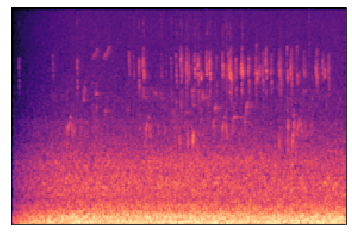

In [52]:
row = df.loc[df['filename'].str.match(file_path)]

for item in row.itertuples(False):
    print(item.primary_label)
    mels = np.load(str((TRAIN_AUDIO_IMAGES_SAVE_ROOT/item.filename).as_posix() + ".npy"))
    print(str((TRAIN_AUDIO_IMAGES_SAVE_ROOT/item.primary_label/item.filename).as_posix() + ".npy"))
    print(mels.shape)
    lbd.specshow(mels[0])

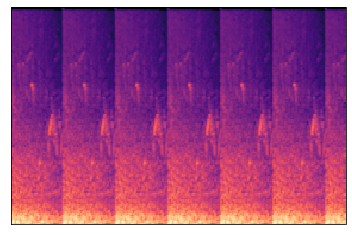

In [54]:
lbd.specshow(mels[2])

In [ ]:
! mv /content/drive/MyDrive/audio_images/afrsil1/afrsil1 /content/drive/MyDrive/audio_images/


mv: cannot move '/content/drive/MyDrive/audio_images/afrsil1/afrsil1' to '/content/drive/MyDrive/audio_images/afrsil1': Directory not empty
